## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [26]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.version.cuda)         # Should show a version, e.g., '12.1'

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print("Using device:", device)

True
12.4
Using device: cpu


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

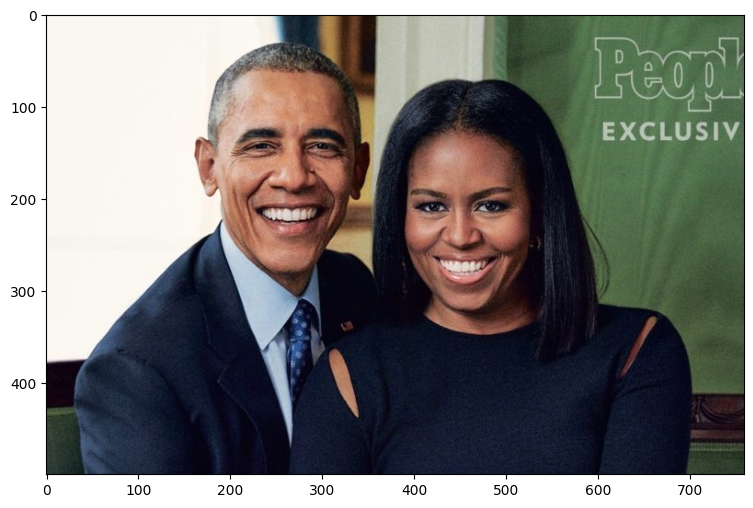

In [27]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


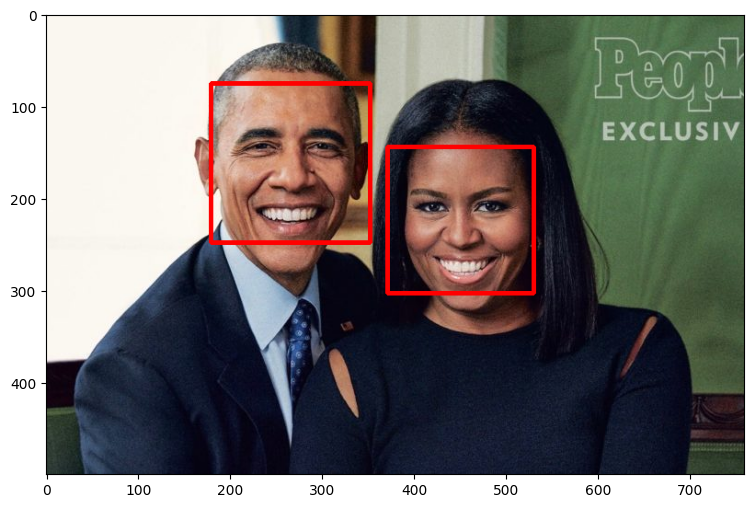

In [28]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

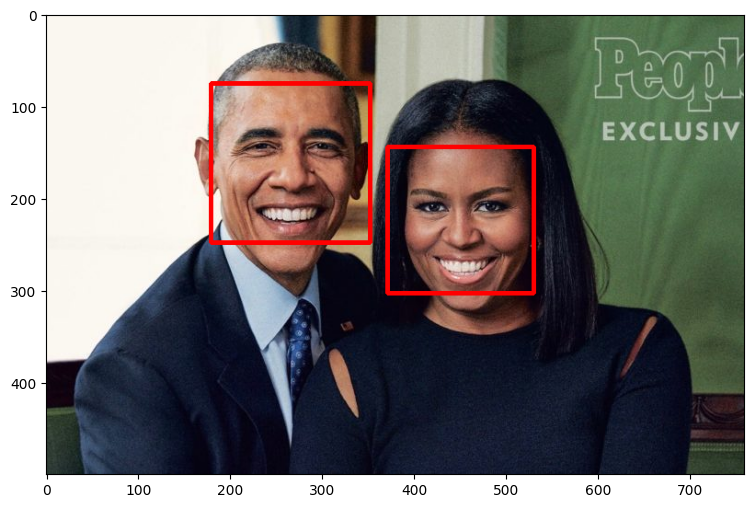

In [29]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
dx = 0
dy = 0
for (x,y,w,h) in faces:
    x = x - dx
    y = y - dy
    w = w + 2 * dx
    h = h + 2 * dy
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [30]:
import torch
from models import Net

model_dir = 'saved_models/'
model_name = 'keypoints_model_3.0.pt'

net = Net()
net.load_state_dict(torch.load(model_dir+model_name))
net.to(device)
net.eval()

flattened_size: 25088


Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.0, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.0, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05,

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [31]:
from matplotlib import pyplot as plt

def predict_and_show(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Determine whether image is already in [0,1] range
    if gray.dtype == np.uint8 or gray.max() > 1.0:
        print('normalizing value range to [0,1]')
        gray = gray / 255.0

    resized = cv2.resize(gray, (224, 224))
    resized = np.expand_dims(resized, axis=0)
    tensor = torch.from_numpy(resized).unsqueeze(0).float()

    net.eval()
    with torch.no_grad():
        tensor = tensor.to(device)
        output_pts = net(tensor)
        output_pts = output_pts.view(1, 68, 2)
        keypoints = output_pts.cpu().numpy().squeeze()
        keypoints = keypoints * 50.0 + 100

    plt.imshow(resized.squeeze(), cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='r')
    plt.axis('equal')
    plt.title(image_path)
    plt.show()

# Try two distinct images
#predict_and_show('data/training/Abdel_Aziz_Al-Hakim_00.jpg')
#predict_and_show('data/training/Charlotte_Rampling_01.jpg')

normalizing value range to [0,1]
normalizing value range to [0,1]


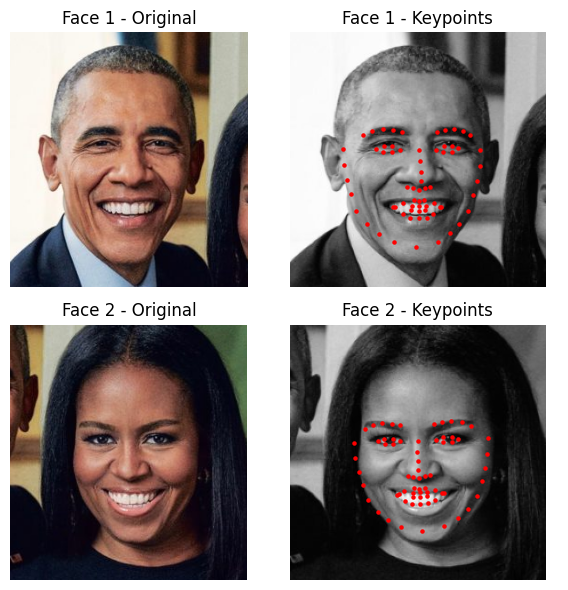

In [34]:
image_copy = np.copy(image)

fig, axes = plt.subplots(len(faces), 2, figsize=(6, 3 * len(faces)))  # One row per face, 2 columns

if len(faces) == 1:
    axes = np.expand_dims(axes, axis=0)  # Ensure axes is always 2D
    
dx = 50
dy = 60
# loop over the detected faces from your haar cascade
for i, (x, y, w, h) in enumerate(faces):
    x = x - dx
    y = y - dy
    w = w + 2 * dx
    h = h + 2 * dy

    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    
    ## Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    # Determine whether image is already in [0,1] range
    if gray.dtype == np.uint8 or gray.max() > 1.0:
        print('normalizing value range to [0,1]')
        gray = gray / 255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    resized = cv2.resize(gray, (224, 224))  # shape: (224, 224)

    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    tensor = np.expand_dims(resized, axis=0) 
    tensor = torch.from_numpy(tensor).type(torch.FloatTensor) 
    tensor = tensor.unsqueeze(0)
    
    ## Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints\net.eval()
    with torch.no_grad():
        tensor = tensor.to(device)  
        output_pts = net(tensor)                  # shape: (1, 136)
        output_pts = output_pts.view(1, 68, 2)    # shape: (1, 68, 2)
        keypoints = output_pts.cpu().numpy().squeeze()  # shape: (68, 2)
        keypoints = keypoints * 50.0 + 100 

    ## Display each detected face and the corresponding keypoints        
    # Plot original ROI
    axes[i, 0].imshow(roi)
    axes[i, 0].set_title(f"Face {i+1} - Original")
    axes[i, 0].axis("off")

    # Plot resized grayscale + keypoints
    axes[i, 1].imshow(resized, cmap='gray')
    axes[i, 1].scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
    axes[i, 1].set_title(f"Face {i+1} - Keypoints")
    axes[i, 1].axis("equal")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()   